Environment Setup--
First, we need to create the grid world environment with all the specified rules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

class GridWorldEnv:
    def __init__(self):
        # Grid dimensions: 5X5
        self.rows = 5
        self.cols = 5


        # Actions: North(0), South(1), East(2), West(3)
        self.actions = [0,1,2,3]

        #Create grid layout (0 = free, 1 = obstacle)
        self.grid = np.zeros((self.rows, self.cols))


        #Set obstacles (black cells in the diagram)
        self.grid[2,2] = 1
        self.grid[2,3] = 1
        self.grid[3,2] = 1


        #Special states
        self.start_state = (1,0) #[2,1] in 1-indexed notation
        self.terminal_state = (4,4) #[5,5] in 1-indexed notation
        self.special_jump = (1,3) #[2,4] in 1-indexed notation
        self.jump_target = (3,3) #[4,4] in 1-indexed notation

        #Total number of states (excluding obstacles)
        self.n_states = self.rows * self.cols - np.sum(self.grid)
        self.n_actions = len(self.actions)

    def reset(self):
        #Reset  to starting position
        return self.start_state

    def step(self, state, action):
        # Current position
        row, col = state

        # Check if it's a terminal state or special jump
        if state == self.terminal_state:
            return state, 0, True  # Already at terminal state

        if state == self.special_jump:
            return self.jump_target, 5, False  # Special jump with +5 reward

        # Calculate new position based on action
        new_row, new_col = row, col

        # North
        if action == 0 and row > 0:
            new_row = row - 1
        # South
        elif action == 1 and row < self.rows - 1:
            new_row = row + 1
        # East
        elif action == 2 and col < self.cols - 1:
            new_col = col + 1
        # West
        elif action == 3 and col > 0:
            new_col = col - 1

        # Check if new position is valid (not an obstacle)
        if 0 <= new_row < self.rows and 0 <= new_col < self.cols and self.grid[new_row, new_col] == 1:
            # Hit obstacle, stay in place
            new_row, new_col = row, col

        # Create the new state
        new_state = (new_row, new_col)

        # Determine reward and done flag
        if new_state == self.terminal_state:
            reward = 10
            done = True
        else:
            reward = -1  # Default reward for all other actions
            done = False

        return new_state, reward, done


    def state_to_idx(self, state):

        #Convert 2D to 1D index
        row, col = state
        return row * self.cols + col

    def idx_to_state(self, idx):

        #Convert 1D index to 2D state
        row = idx // self.cols
        col = idx % self.cols
        return (row, col)


Q-Learning Agent Implementation --
Now, let's implement the Q-learning agent with epsilon-greedy exploration

In [2]:
class QLearningAgent:
    def __init__(self, env, learning_rate=1.0, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Initialize Q-table with zeros
        self.q_table = np.zeros((env.rows * env.cols, env.n_actions))

    def choose_action(self, state):
        state_idx = self.env.state_to_idx(state)

        # Epsilon-greedy action selection
        if random.random() < self.epsilon:
            # Explore: choose a random action
            return random.choice(self.env.actions)
        else:
            # Exploit: choose the best action from Q-table
            return np.argmax(self.q_table[state_idx])

    def learn(self, state, action, reward, next_state, done):
        state_idx = self.env.state_to_idx(state)
        next_state_idx = self.env.state_to_idx(next_state)

        # Q-learning formula: Q(s,a) = Q(s,a) + α * [r + γ * max(Q(s',a')) - Q(s,a)]
        if not done:
            target = reward + self.discount_factor * np.max(self.q_table[next_state_idx])
        else:
            target = reward

        # Update Q-value
        self.q_table[state_idx, action] += self.learning_rate * (target - self.q_table[state_idx, action])

    def decay_epsilon(self):
        # Decay epsilon for exploration-exploitation trade-off
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

In [3]:
class QLearningAgent:
    def __init__(self, env, learning_rate=1.0, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01):
        print(f"Creating agent with env type: {type(env)}, learning_rate: {learning_rate}")
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Initialize Q-table with zeros
        try:
            print(f"env.rows: {env.rows}, env.cols: {env.cols}, env.n_actions: {env.n_actions}")
            self.q_table = np.zeros((env.rows * env.cols, env.n_actions))
            print("Q-table created successfully")
        except Exception as e:
            print(f"Error creating Q-table: {str(e)}")
            raise


    def choose_action(self, state):
        state_idx = self.env.state_to_idx(state)

        #Epsilon-greedy action selection
        if random.random() < self.epsilon:

            #Explore: choose a random action
            return  random.choice(self.env.actions)

        else:

            #Exploit: choose the best option from Q-table
            return np.argmax(self.q_table[state_idx])

    def learn(self, state, action, reward, next_state, done):
        state_idx = self.env.state_to_idx(state)
        next_state_idx = self.env.state_to_idx(next_state)

        # Q-learning formula: Q(s,a) = Q(s,a) + α * [r + γ * max(Q(s',a')) - Q(s,a)]
        if not done:
            target = reward + self.discount_factor * np.max(self.q_table[next_state_idx])
        else:
            target = reward

        # Update Q-value
        self.q_table[state_idx, action] += self.learning_rate * (target - self.q_table[state_idx, action])


    def decay_epsilon(self):

        #Decay epsilon for Exploration-Exploitation trade-off
        self.epsilon = max(self.min_epsilon, self.epsilon_decay * self.epsilon)


Training the Agent --
Now let's implement the training process with the stopping criterion

In [4]:
def train_agent(env, agent, max_episodes=100, max_steps=100):
    # List to store rewards for each episode
    episode_rewards = []

    # For stopping criterion: track average reward over 30 consecutive episodes
    recent_rewards = []

    for episode in range(max_episodes):
        # Reset environment
        state = env.reset()
        total_reward = 0
        done = False
        step = 0

        while not done and step < max_steps:
            # Choose action
            action = agent.choose_action(state)

            # Take action - FIXED LINE
            next_state, reward, done = env.step(state, action)

            # Update Q-table
            agent.learn(state, action, reward, next_state, done)

            # Update state and reward
            state = next_state
            total_reward += reward
            step += 1

        # Decay epsilon for next episode
        agent.decay_epsilon()

        # Track rewards
        episode_rewards.append(total_reward)
        recent_rewards.append(total_reward)

        # Keep only the last 30 episodes for the stopping criterion
        if len(recent_rewards) > 30:
            recent_rewards.pop(0)

        # Print progress
        if (episode + 1) % 10 == 0:
            print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.4f}")

        # Check stopping criterion: average reward > 10 over 30 consecutive episodes
        if len(recent_rewards) == 30 and np.mean(recent_rewards) > 10:
            print(f"Stopping at episode {episode + 1}: Average reward over last 30 episodes > 10")
            break

    return episode_rewards

 Visualization Functions --
Let's implement functions to visualize the state values

In [5]:
def visualise_state_values(env, agent):

    #Create a grid to hold state values
    state_values = np.zeros((env.rows, env.cols))

    #Fill with NaN for obstacles to distinguish them in the plot
    state_values.fill(np.nan)

    #Calculate state values from Q-values (max Q-value for each state)
    for row in range(env.rows):
        for col in range(env.cols):
            state = (row, col)
            if env.grid[row, col] == 0:
                state_idx = env.state_to_idx(state)
                state_values[row, col] = np.max(agent.q_table[state_idx])

    #Create a mask for obstacles
    obstacle_mask = (env.grid == 1)

    #Create a mask for special states
    special_states = np.zeros((env.rows, env.cols))
    special_states[env.start_state] = 1
    special_states[env.terminal_state] = 2
    special_states[env.special_jump] = 3
    special_states[env.jump_target] = 4

    #Plot the grid
    plt.figure(figsize=(10, 8))

    #Plot state values
    sns.heatmap(state_values, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True)

    #Mark obstacles with black
    for row in range(env.rows):
        for col in range(env.cols):
            if obstacle_mask[row, col]:
                plt.text(col + 0.5, row + 0.5, "x", fontsize = 20, ha="center", va="center", color="white")
                plt.gca().add_patch(plt.Rectangle((col, row), 1, 1, fill=True, color="black"))

    #Mark Special states
    plt.text(env.start_state[1] + 0.5, env.start_state[0] + 0.5, "S", fontsize=20, ha='center', va='center', color='red')
    plt.text(env.terminal_state[1] + 0.5, env.terminal_state[0] + 0.5, "T\n+10", fontsize=15, ha='center', va='center', color='blue')
    plt.text(env.special_jump[1] + 0.5, env.special_jump[0] + 0.5, "J\n+5", fontsize=15, ha='center', va='center', color='green')


    #Add arrow from jump to target
    plt.arrow(env.special_jump[1] + 0.5, env.special_jump[0] + 0.5,
              env.jump_target[1] - env.special_jump[1], env.jump_target[0] - env.special_jump[0],
              head_width=0.2, head_length=0.2, fc='green', ec='green')

    plt.title("State Values in Grid World")
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.tight_layout()
    plt.savefig('grid_world_state_values.png')
    plt.show()

def plot_rewards(rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.savefig('rewards_per_episode.png')
    plt.show()


Training with learning rate = 1.0
Creating agent with env type: <class '__main__.GridWorldEnv'>, learning_rate: 1.0
env.rows: 5, env.cols: 5, env.n_actions: 4
Q-table created successfully
Episode: 10, Total Reward: -4, Epsilon: 0.9511
Episode: 20, Total Reward: 11, Epsilon: 0.9046
Episode: 30, Total Reward: -7, Epsilon: 0.8604
Episode: 40, Total Reward: 4, Epsilon: 0.8183
Episode: 50, Total Reward: 6, Epsilon: 0.7783
Episode: 60, Total Reward: -5, Epsilon: 0.7403
Episode: 70, Total Reward: -2, Epsilon: 0.7041
Episode: 80, Total Reward: 7, Epsilon: 0.6696
Episode: 90, Total Reward: 0, Epsilon: 0.6369
Episode: 100, Total Reward: 9, Epsilon: 0.6058

Training with learning rate = 0.8
Creating agent with env type: <class '__main__.GridWorldEnv'>, learning_rate: 0.8
env.rows: 5, env.cols: 5, env.n_actions: 4
Q-table created successfully
Episode: 10, Total Reward: -44, Epsilon: 0.9511
Episode: 20, Total Reward: -12, Epsilon: 0.9046
Episode: 30, Total Reward: -11, Epsilon: 0.8604
Episode: 40,

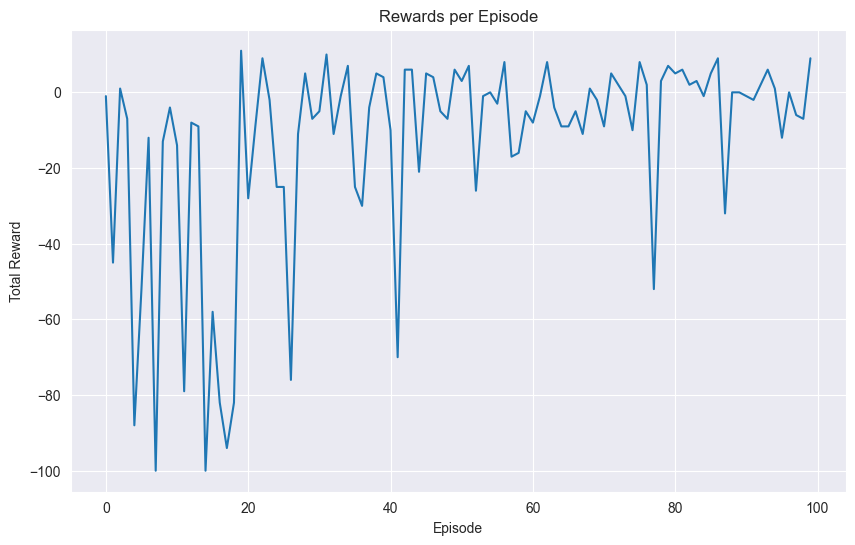

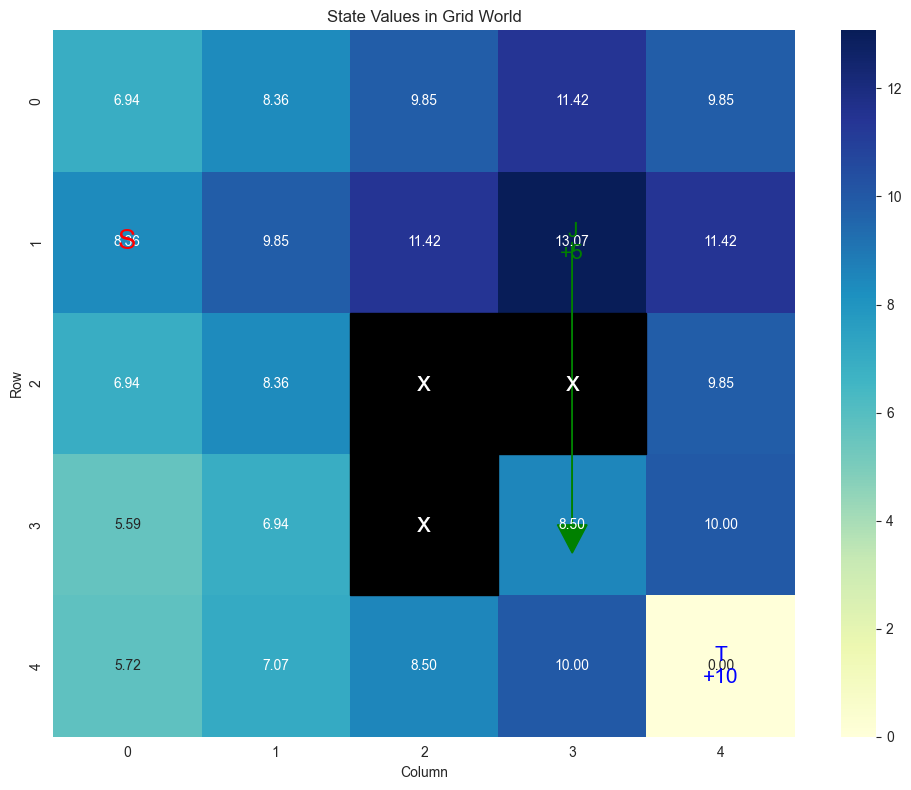

In [6]:
def main():
    # Create environment and agent
    env = GridWorldEnv()

    # Test with different learning rates
    learning_rates = [1.0, 0.8, 0.5, 0.2]
    results = {}

    for lr in learning_rates:
        print(f"\nTraining with learning rate = {lr}")
        agent = QLearningAgent(env, learning_rate=lr)
        rewards = train_agent(env, agent)
        results[lr] = {
            'agent': agent,
            'rewards': rewards
        }

    # Visualize results for the agent with learning rate = 1.0
    agent = results[1.0]['agent']
    rewards = results[1.0]['rewards']

    # Plot learning curve
    plot_rewards(rewards)

    # Visualize state values
    visualise_state_values(env, agent)

if __name__ == "__main__":
    main()